In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
from transformers import AutoModel
import sys 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup

sys.path.insert(0, "/home/sumon/workspace/git_repos/multi_task_nlp")


from src.dataset import load_dataset
from src.train   import train_model
from src.models  import ATISMultiTaskModel as Model
from src.models  import SentenceEncoder as Encoder
from src.utils   import plot_metrics


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_ds, val_ds = load_dataset('/home/sumon/workspace/git_repos/multi_task_nlp/data')

def collate_batch(batch):
    return {k: torch.stack([b[k] for b in batch]) for k in batch[0]}

loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_batch)


# encoder = Encoder("bert-base-uncased")
encoder = Encoder("custom", 512)
model = Model(encoder).to(device)


/home/sumon/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [3]:
# train_ds = train_ds[:600]
# val_ds = val_ds[:200]

In [4]:
metrics = train_model(train_ds, val_ds, model, epochs=2)

RuntimeError: The size of tensor a (128) must match the size of tensor b (100) at non-singleton dimension 0

In [5]:
df = pd.DataFrame(metrics)

df.round(2)

,train_loss,train_intent_loss,train_entity_loss,train_intent_acc,train_entity_f1,val_loss,val_intent_loss,val_entity_loss,val_intent_acc,val_entity_f1,epoch
0,2.23,1.25,0.98,0.68,0.17,1.81,1.12,0.69,0.71,0.19,0
1,1.77,1.04,0.73,0.73,0.18,1.77,1.10,0.67,0.71,0.19,1


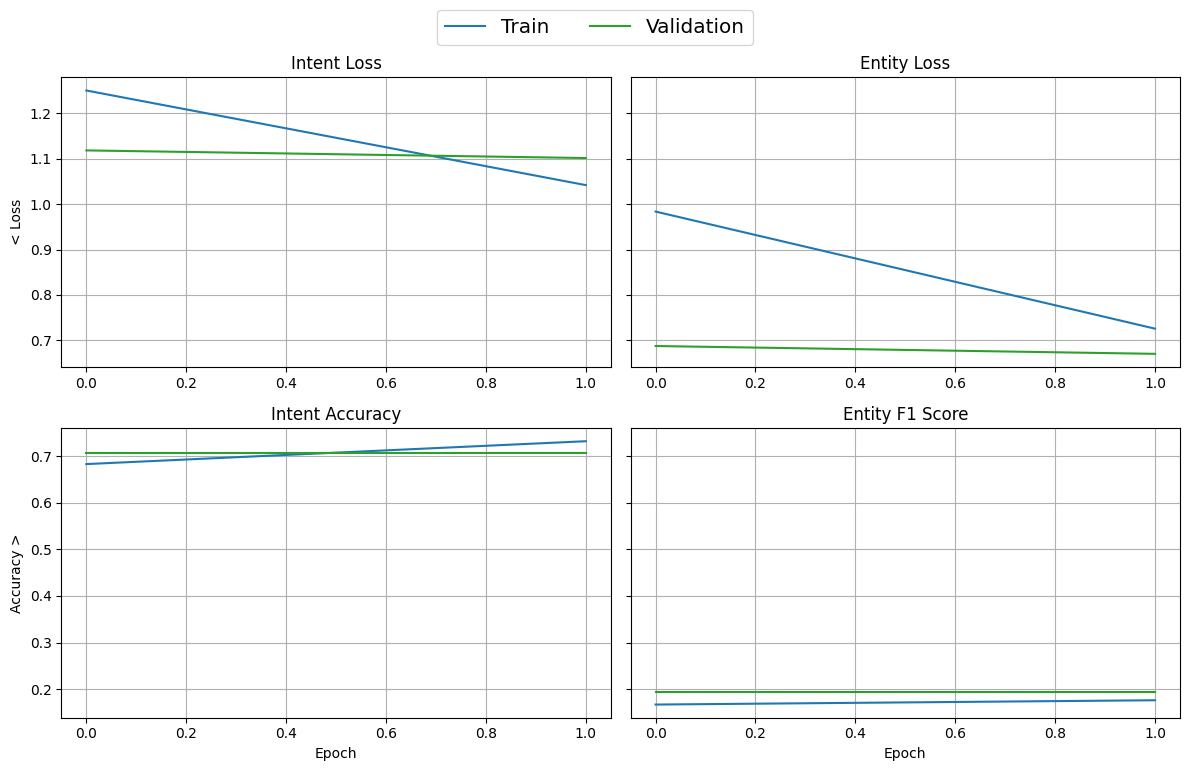

In [ ]:

    
plot_metrics(metrics)

In [6]:
help(AutoModel.from_pretrained)

Help on method from_pretrained in module transformers.models.auto.auto_factory:

from_pretrained(*model_args, **kwargs) method of builtins.type instance
    Instantiate one of the base model classes of the library from a pretrained model.
    
    The model class to instantiate is selected based on the `model_type` property of the config object (either
    passed as an argument or loaded from `pretrained_model_name_or_path` if possible), or when it's missing, by
    falling back to using pattern matching on `pretrained_model_name_or_path`:
    
        - **albert** -- [`AlbertModel`] (ALBERT model)
        - **align** -- [`AlignModel`] (ALIGN model)
        - **altclip** -- [`AltCLIPModel`] (AltCLIP model)
        - **aria** -- [`AriaForConditionalGeneration`] (Aria model)
        - **aria_text** -- [`AriaTextModel`] (AriaText model)
        - **audio-spectrogram-transformer** -- [`ASTModel`] (Audio Spectrogram Transformer model)
        - **autoformer** -- [`AutoformerModel`] (Autofor

In [ ]:
record         = val_ds[130]
input_ids      = record['input_ids'].unsqueeze(0).to(device)
attention_mask = record['attention_mask'].unsqueeze(0).to(device)

with torch.no_grad():
    intent, slots = model(input_ids, attention_mask)

preds_intent = torch.argmax(intent, dim=-1).cpu().tolist()
preds_slots  = torch.argmax(slots, dim=-1).cpu().tolist()


AssertionError: only bool and floating types of mask are supported

In [ ]:
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]], device='cuda:0')

In [ ]:
id2slot = {v:k for k, v in val_ds.slot2id.items()}
id2intent = {v:k for k, v in val_ds.intent2id.items()}

In [ ]:
print(id2intent[preds_intent[0]], [id2slot[i] for i in preds_slots[0] if i != 0])

print(id2intent[record['intent_label'].tolist()], [id2slot[i] for i in record['slot_labels'].tolist() if i != 0])


Flight ['X', 'X', 'X', 'X', 'X', 'Location', 'X', 'Location', 'Location', 'X', 'DateTime', 'DateTime', 'X', 'DateTime', 'DateTime']
Flight ['X', 'X', 'X', 'X', 'X', 'Location', 'X', 'Location', 'Location', 'X', 'DateTime', 'DateTime', 'Modifier', 'DateTime', 'DateTime']


5

In [ ]:
intent

tensor([[-1.2689, -0.9376, -1.6344, -1.6462,  6.9766, -0.8103, -0.6252, -1.3814]],
       device='cuda:0')